# 02 - Feature Engineering

This notebook implements feature engineering for Sri Lanka tourism forecasting.

## Design Principles

1. **Parity Layer**: Shared core feature set for all models
2. **Minimal Features**: Small dataset (91 observations) requires avoiding overfitting
3. **No Leakage**: All features strictly use past data or deterministically known future values
4. **Interpretability**: Each feature has clear business meaning

## Feature Categories

- **Temporal Features**: Year, month, quarter (for all models)
- **Cyclical Encoding**: Sine/cosine month (for neural networks)
- **Lag Features**: 1, 3, 6, 12 months (for ML/DL models)
- **Rolling Statistics**: 3, 12 month averages (optional, computed on past data only)
- **Intervention Features**: Binary flags for Easter attacks, COVID-19, economic crisis
- **Recovery Index**: Smooth continuous measure of post-COVID recovery

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Import custom preprocessing functions
sys.path.append('../scripts')
from preprocessing import (
    create_time_features,
    create_cyclical_features,
    create_lag_features,
    create_rolling_features,
    create_intervention_features,
    create_recovery_index,
    handle_missing_values
)

%matplotlib inline
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data

Load the filtered dataset (Jan 2017 - Jul 2024, 91 observations)

In [2]:
# Load the filtered dataset
df = pd.read_csv('../data/processed/monthly_tourist_arrivals_filtered.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst rows:")
df.head()

Dataset shape: (91, 2)
Date range: 2017-01-01 00:00:00 to 2024-07-01 00:00:00

First rows:


,Date,Arrivals
0,2017-01-01,219360
1,2017-02-01,197517
2,2017-03-01,188076
3,2017-04-01,160249
4,2017-05-01,121891


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
df.describe()

Missing values:
Date        0
Arrivals    0
dtype: int64

Basic statistics:


,Date,Arrivals
count,91,91.000000
mean,2020-09-30 13:58:40.879120896,115070.813187
min,2017-01-01 00:00:00,0.000000
25%,2018-11-16 00:00:00,37781.000000
50%,2020-10-01 00:00:00,113470.000000
75%,2022-08-16 12:00:00,187943.000000
max,2024-07-01 00:00:00,253169.000000
std,NaN,81696.225334


## 2. Core Temporal Features (Parity Layer)

These features are available to all models.

In [4]:
# Create temporal features
df_features = create_time_features(df, 'Date')

print("Temporal features added:")
print(df_features[['Date', 'year', 'month', 'quarter']].head(10))

Temporal features added:
        Date  year  month  quarter
0 2017-01-01  2017      1        1
1 2017-02-01  2017      2        1
2 2017-03-01  2017      3        1
3 2017-04-01  2017      4        2
4 2017-05-01  2017      5        2
5 2017-06-01  2017      6        2
6 2017-07-01  2017      7        3
7 2017-08-01  2017      8        3
8 2017-09-01  2017      9        3
9 2017-10-01  2017     10        4


## 3. Cyclical Encoding (For Neural Networks)

Sine and cosine transformations preserve the cyclical nature of months.

Cyclical features added:
         Date  month     month_sin     month_cos
0  2017-01-01      1  5.000000e-01  8.660254e-01
1  2017-02-01      2  8.660254e-01  5.000000e-01
2  2017-03-01      3  1.000000e+00  6.123234e-17
3  2017-04-01      4  8.660254e-01 -5.000000e-01
4  2017-05-01      5  5.000000e-01 -8.660254e-01
5  2017-06-01      6  1.224647e-16 -1.000000e+00
6  2017-07-01      7 -5.000000e-01 -8.660254e-01
7  2017-08-01      8 -8.660254e-01 -5.000000e-01
8  2017-09-01      9 -1.000000e+00 -1.836970e-16
9  2017-10-01     10 -8.660254e-01  5.000000e-01
10 2017-11-01     11 -5.000000e-01  8.660254e-01
11 2017-12-01     12 -2.449294e-16  1.000000e+00
12 2018-01-01      1  5.000000e-01  8.660254e-01
13 2018-02-01      2  8.660254e-01  5.000000e-01
14 2018-03-01      3  1.000000e+00  6.123234e-17


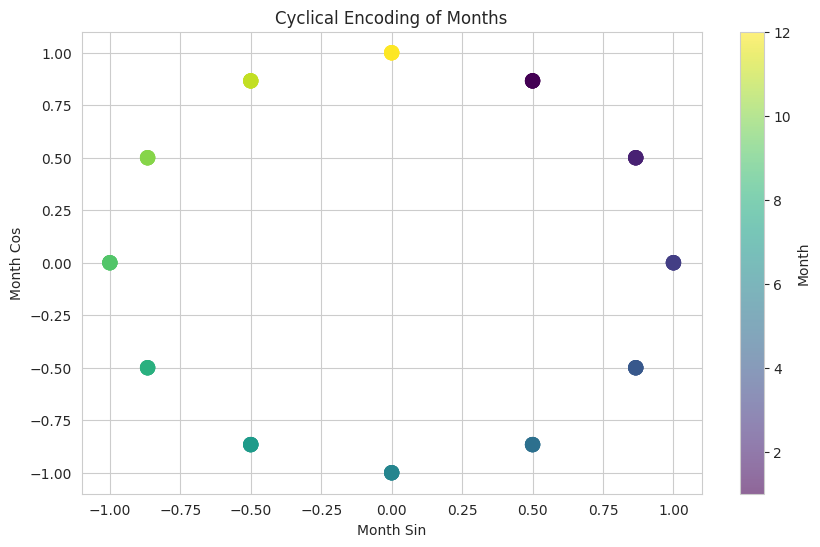

In [5]:
# Add cyclical encoding
df_features = create_cyclical_features(df_features, 'Date')

print("Cyclical features added:")
print(df_features[['Date', 'month', 'month_sin', 'month_cos']].head(15))

# Visualize cyclical encoding
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_features['month_sin'], df_features['month_cos'], 
           c=df_features['month'], cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('Month Sin')
ax.set_ylabel('Month Cos')
ax.set_title('Cyclical Encoding of Months')
plt.colorbar(ax.collections[0], label='Month')
plt.show()

## 4. Intervention/Event Features

Binary flags for known structural shocks. These are deterministically known at forecast time.

In [6]:
# Add intervention features
df_features = create_intervention_features(df_features, 'Date')

print("Intervention features added:")
print(df_features[['Date', 'easter_attacks', 'covid_period', 'economic_crisis']].head(30))

# Summary of intervention periods
print("\nIntervention summary:")
print(f"Easter attacks (Apr 2019): {df_features['easter_attacks'].sum()} month(s)")
print(f"COVID period (Mar 2020 - Dec 2021): {df_features['covid_period'].sum()} months")
print(f"Economic crisis (2022+): {df_features['economic_crisis'].sum()} months")

Intervention features added:
         Date  easter_attacks  covid_period  economic_crisis
0  2017-01-01               0             0                0
1  2017-02-01               0             0                0
2  2017-03-01               0             0                0
3  2017-04-01               0             0                0
4  2017-05-01               0             0                0
5  2017-06-01               0             0                0
6  2017-07-01               0             0                0
7  2017-08-01               0             0                0
8  2017-09-01               0             0                0
9  2017-10-01               0             0                0
10 2017-11-01               0             0                0
11 2017-12-01               0             0                0
12 2018-01-01               0             0                0
13 2018-02-01               0             0                0
14 2018-03-01               0             0             

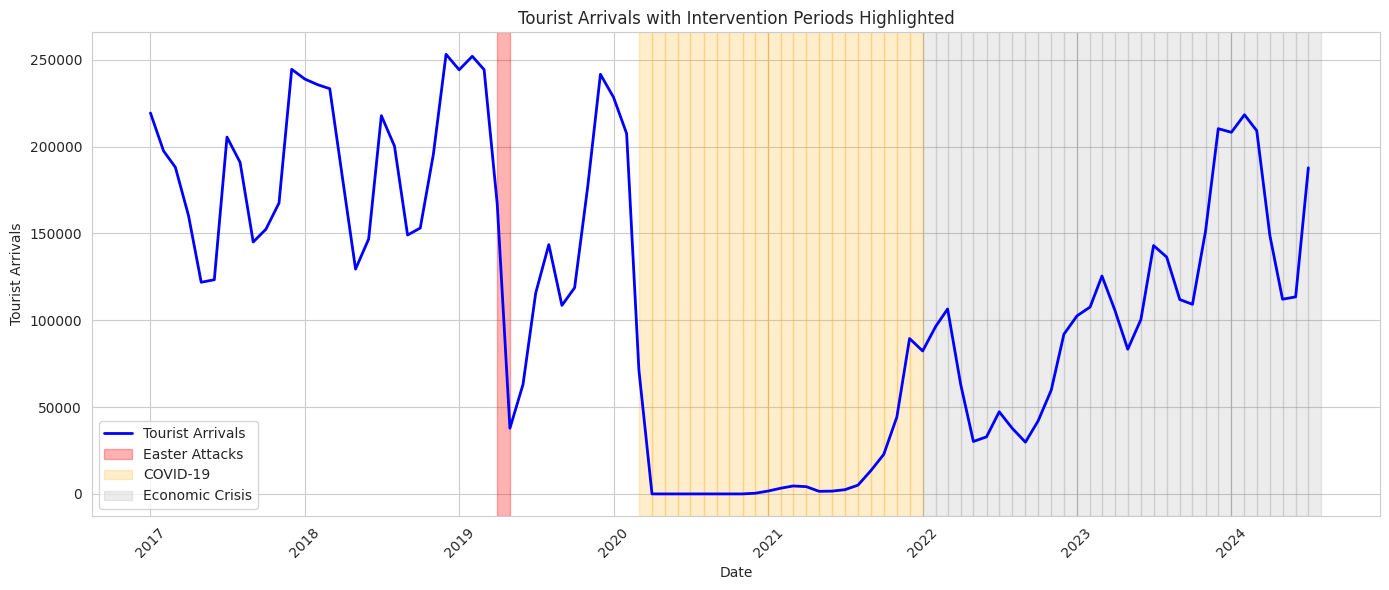

In [7]:
# Visualize interventions over time
fig, ax = plt.subplots(figsize=(14, 6))

# Plot arrivals
ax.plot(df_features['Date'], df_features['Arrivals'], 'b-', linewidth=2, label='Tourist Arrivals')

# Highlight intervention periods
easter_idx = df_features[df_features['easter_attacks'] == 1].index
covid_idx = df_features[df_features['covid_period'] == 1].index
crisis_idx = df_features[df_features['economic_crisis'] == 1].index

for idx in easter_idx:
    ax.axvspan(df_features.loc[idx, 'Date'], 
               df_features.loc[idx, 'Date'] + pd.DateOffset(months=1),
               alpha=0.3, color='red', label='Easter Attacks' if idx == easter_idx[0] else '')

for idx in covid_idx:
    ax.axvspan(df_features.loc[idx, 'Date'], 
               df_features.loc[idx, 'Date'] + pd.DateOffset(months=1),
               alpha=0.2, color='orange', label='COVID-19' if idx == covid_idx[0] else '')

for idx in crisis_idx:
    ax.axvspan(df_features.loc[idx, 'Date'], 
               df_features.loc[idx, 'Date'] + pd.DateOffset(months=1),
               alpha=0.15, color='gray', label='Economic Crisis' if idx == crisis_idx[0] else '')

ax.set_xlabel('Date')
ax.set_ylabel('Tourist Arrivals')
ax.set_title('Tourist Arrivals with Intervention Periods Highlighted')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Recovery Index

Smooth continuous measure of post-COVID recovery progression.

Recovery index added:
         Date  months_since_covid  recovery_index
71 2022-12-01           33.015769        0.550263
72 2023-01-01           34.034166        0.567236
73 2023-02-01           35.052562        0.584209
74 2023-03-01           35.972405        0.599540
75 2023-04-01           36.990802        0.616513
76 2023-05-01           37.976347        0.632939
77 2023-06-01           38.994744        0.649912
78 2023-07-01           39.980289        0.666338
79 2023-08-01           40.998686        0.683311
80 2023-09-01           42.017083        0.700285
81 2023-10-01           43.002628        0.716710
82 2023-11-01           44.021025        0.733684
83 2023-12-01           45.006570        0.750110
84 2024-01-01           46.024967        0.767083
85 2024-02-01           47.043364        0.784056
86 2024-03-01           47.996058        0.799934
87 2024-04-01           49.014455        0.816908
88 2024-05-01           50.000000        0.833333
89 2024-06-01           51.0

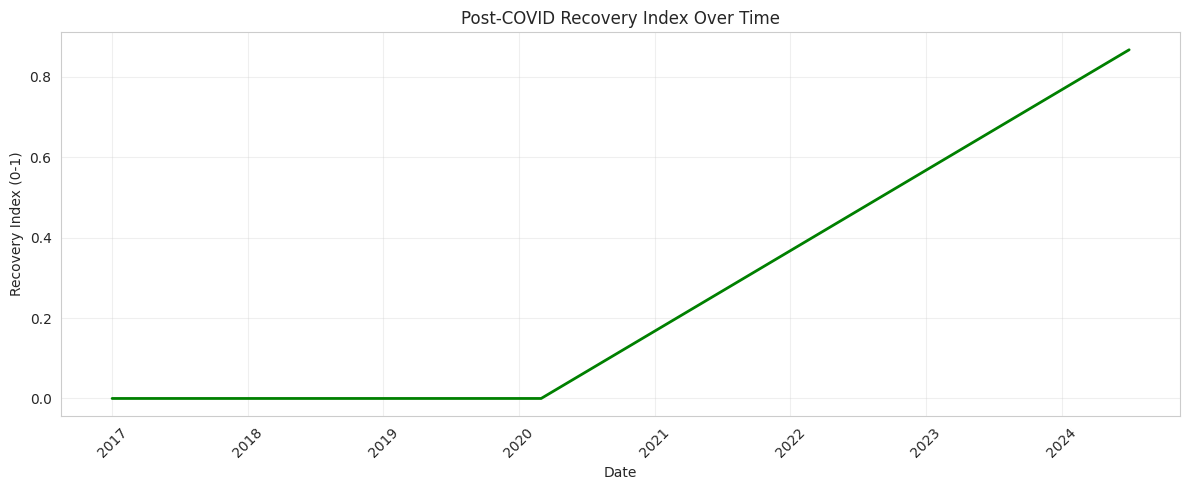

In [8]:
# Add recovery index
df_features = create_recovery_index(df_features, 'Date')

print("Recovery index added:")
print(df_features[['Date', 'months_since_covid', 'recovery_index']].tail(20))

# Visualize recovery index
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_features['Date'], df_features['recovery_index'], 'g-', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Recovery Index (0-1)')
ax.set_title('Post-COVID Recovery Index Over Time')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Lag Features (For ML/DL Models)

Create lag features at key intervals:
- 1 month: Recent trend
- 3 months: Quarterly pattern
- 6 months: Semi-annual pattern
- 12 months: Year-over-year comparison

**Note**: These create NaN values at the start of the series.

In [9]:
# Create lag features
lags = [1, 3, 6, 12]
df_features = create_lag_features(df_features, 'Arrivals', lags)

print("Lag features added:")
print(df_features[['Date', 'Arrivals', 'Arrivals_lag_1', 'Arrivals_lag_3', 
                     'Arrivals_lag_6', 'Arrivals_lag_12']].head(15))

# Check missing values after lag creation
print("\nMissing values in lag features:")
lag_cols = [col for col in df_features.columns if 'lag' in col]
print(df_features[lag_cols].isnull().sum())

Lag features added:
         Date  Arrivals  Arrivals_lag_1  Arrivals_lag_3  Arrivals_lag_6  \
0  2017-01-01    219360             NaN             NaN             NaN   
1  2017-02-01    197517        219360.0             NaN             NaN   
2  2017-03-01    188076        197517.0             NaN             NaN   
3  2017-04-01    160249        188076.0        219360.0             NaN   
4  2017-05-01    121891        160249.0        197517.0             NaN   
5  2017-06-01    123351        121891.0        188076.0             NaN   
6  2017-07-01    205482        123351.0        160249.0        219360.0   
7  2017-08-01    190928        205482.0        121891.0        197517.0   
8  2017-09-01    145077        190928.0        123351.0        188076.0   
9  2017-10-01    152429        145077.0        205482.0        160249.0   
10 2017-11-01    167511        152429.0        190928.0        121891.0   
11 2017-12-01    244536        167511.0        145077.0        123351.0   
12 20

## 7. Rolling Window Statistics (Optional)

Computed only on past data to avoid leakage:
- 3-month rolling average: Short-term trend
- 12-month rolling average: Long-term trend

**Important**: These features can only be used if we ensure they're computed without future information during model training.

Rolling features added:
         Date  Arrivals  Arrivals_rolling_mean_3  Arrivals_rolling_mean_12
0  2017-01-01    219360                      NaN                       NaN
1  2017-02-01    197517                      NaN                       NaN
2  2017-03-01    188076            201651.000000                       NaN
3  2017-04-01    160249            181947.333333                       NaN
4  2017-05-01    121891            156738.666667                       NaN
5  2017-06-01    123351            135163.666667                       NaN
6  2017-07-01    205482            150241.333333                       NaN
7  2017-08-01    190928            173253.666667                       NaN
8  2017-09-01    145077            180495.666667                       NaN
9  2017-10-01    152429            162811.333333                       NaN
10 2017-11-01    167511            155005.666667                       NaN
11 2017-12-01    244536            188158.666667             176367.250000
1

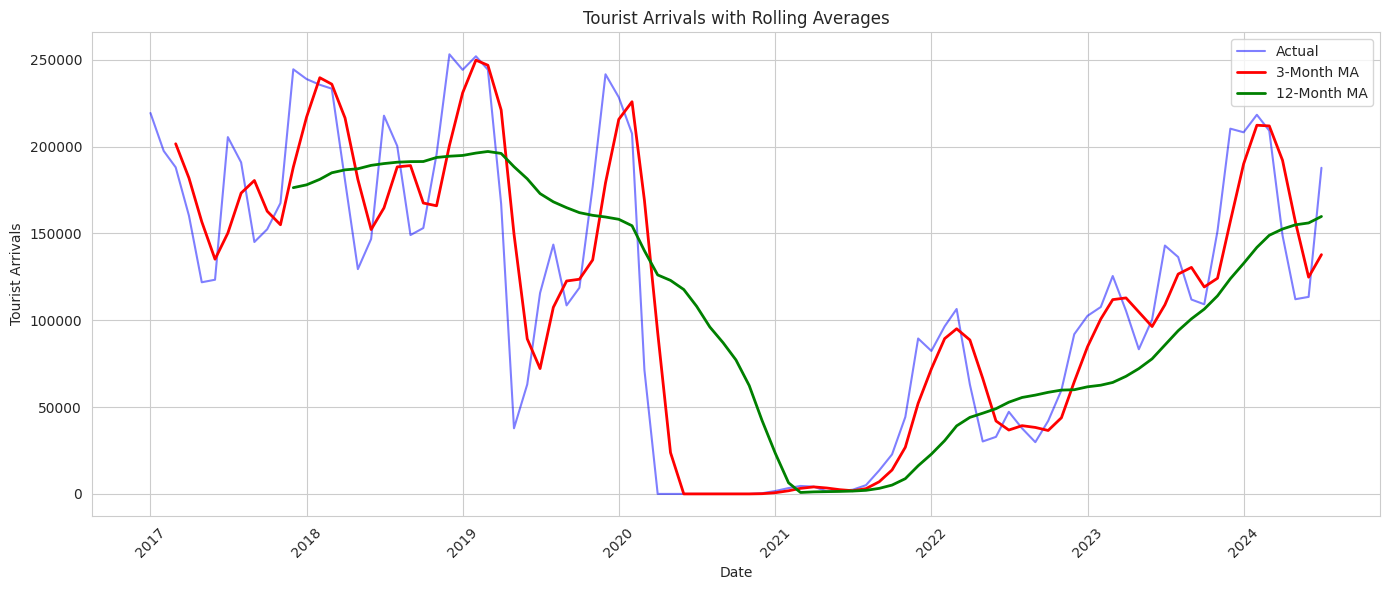

In [10]:
# Create rolling features
windows = [3, 12]
df_features = create_rolling_features(df_features, 'Arrivals', windows)

print("Rolling features added:")
print(df_features[['Date', 'Arrivals', 'Arrivals_rolling_mean_3', 
                     'Arrivals_rolling_mean_12']].head(15))

# Visualize rolling averages
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_features['Date'], df_features['Arrivals'], 'b-', alpha=0.5, label='Actual')
ax.plot(df_features['Date'], df_features['Arrivals_rolling_mean_3'], 'r-', 
        linewidth=2, label='3-Month MA')
ax.plot(df_features['Date'], df_features['Arrivals_rolling_mean_12'], 'g-', 
        linewidth=2, label='12-Month MA')
ax.set_xlabel('Date')
ax.set_ylabel('Tourist Arrivals')
ax.set_title('Tourist Arrivals with Rolling Averages')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Feature Summary and Selection

Review all created features and prepare different feature sets for different models.

In [11]:
# Summary of all features
print("All features created:")
print(f"Total columns: {len(df_features.columns)}")
print("\nColumn list:")
for i, col in enumerate(df_features.columns, 1):
    print(f"{i}. {col}")

print("\nDataset shape:", df_features.shape)
print("\nMissing values summary:")
print(df_features.isnull().sum())

All features created:
Total columns: 20

Column list:
1. Date
2. Arrivals
3. year
4. month
5. quarter
6. month_sin
7. month_cos
8. easter_attacks
9. covid_period
10. economic_crisis
11. months_since_covid
12. recovery_index
13. Arrivals_lag_1
14. Arrivals_lag_3
15. Arrivals_lag_6
16. Arrivals_lag_12
17. Arrivals_rolling_mean_3
18. Arrivals_rolling_std_3
19. Arrivals_rolling_mean_12
20. Arrivals_rolling_std_12

Dataset shape: (91, 20)

Missing values summary:
Date                         0
Arrivals                     0
year                         0
month                        0
quarter                      0
month_sin                    0
month_cos                    0
easter_attacks               0
covid_period                 0
economic_crisis              0
months_since_covid           0
recovery_index               0
Arrivals_lag_1               1
Arrivals_lag_3               3
Arrivals_lag_6               6
Arrivals_lag_12             12
Arrivals_rolling_mean_3      2
Arrivals_r

In [12]:
# Define feature sets for different model families

# Core features (available to all models)
core_features = ['Date', 'Arrivals', 'year', 'month', 'quarter']

# Intervention features (for Prophet as regressors, for ML/DL as inputs)
intervention_features = ['easter_attacks', 'covid_period', 'economic_crisis', 'recovery_index']

# Cyclical features (primarily for neural networks)
cyclical_features = ['month_sin', 'month_cos']

# Lag features (for ML/DL models)
lag_features = [col for col in df_features.columns if 'lag' in col]

# Rolling features (optional, use with caution)
rolling_features = [col for col in df_features.columns if 'rolling' in col]

print("Feature Sets:")
print(f"\nCore: {core_features}")
print(f"\nIntervention: {intervention_features}")
print(f"\nCyclical: {cyclical_features}")
print(f"\nLag: {lag_features}")
print(f"\nRolling: {rolling_features}")

Feature Sets:

Core: ['Date', 'Arrivals', 'year', 'month', 'quarter']

Intervention: ['easter_attacks', 'covid_period', 'economic_crisis', 'recovery_index']

Cyclical: ['month_sin', 'month_cos']

Lag: ['Arrivals_lag_1', 'Arrivals_lag_3', 'Arrivals_lag_6', 'Arrivals_lag_12']

Rolling: ['Arrivals_rolling_mean_3', 'Arrivals_rolling_std_3', 'Arrivals_rolling_mean_12', 'Arrivals_rolling_std_12']


## 9. Save Engineered Features

Save different versions:
1. **Full features**: All features for exploration
2. **Prophet features**: Core + interventions (no lags, Prophet handles seasonality)
3. **ML/DL features**: Core + interventions + cyclical + lags (may include rolling)

In [13]:
# Save full feature set
output_path_full = '../data/processed/monthly_tourist_arrivals_features_full.csv'
df_features.to_csv(output_path_full, index=False)
print(f"Full features saved to: {output_path_full}")
print(f"Shape: {df_features.shape}")

# Save Prophet-ready features (no lags, Prophet will handle seasonality internally)
prophet_cols = core_features + intervention_features
df_prophet = df_features[prophet_cols].copy()
output_path_prophet = '../data/processed/monthly_tourist_arrivals_features_prophet.csv'
df_prophet.to_csv(output_path_prophet, index=False)
print(f"\nProphet features saved to: {output_path_prophet}")
print(f"Shape: {df_prophet.shape}")
print(f"Columns: {list(df_prophet.columns)}")

# Save ML/DL features (drop rows with NaN from lags for some models)
ml_cols = core_features + intervention_features + cyclical_features + lag_features
df_ml = df_features[ml_cols].copy()
output_path_ml = '../data/processed/monthly_tourist_arrivals_features_ml.csv'
df_ml.to_csv(output_path_ml, index=False)
print(f"\nML/DL features (with NaN) saved to: {output_path_ml}")
print(f"Shape: {df_ml.shape}")
print(f"Missing values: {df_ml.isnull().sum().sum()}")

# Save ML/DL features without NaN (drop first 12 rows)
df_ml_clean = df_ml.dropna().reset_index(drop=True)
output_path_ml_clean = '../data/processed/monthly_tourist_arrivals_features_ml_clean.csv'
df_ml_clean.to_csv(output_path_ml_clean, index=False)
print(f"\nML/DL features (clean) saved to: {output_path_ml_clean}")
print(f"Shape: {df_ml_clean.shape}")
print(f"Date range: {df_ml_clean['Date'].min()} to {df_ml_clean['Date'].max()}")

Full features saved to: ../data/processed/monthly_tourist_arrivals_features_full.csv
Shape: (91, 20)

Prophet features saved to: ../data/processed/monthly_tourist_arrivals_features_prophet.csv
Shape: (91, 9)
Columns: ['Date', 'Arrivals', 'year', 'month', 'quarter', 'easter_attacks', 'covid_period', 'economic_crisis', 'recovery_index']

ML/DL features (with NaN) saved to: ../data/processed/monthly_tourist_arrivals_features_ml.csv
Shape: (91, 15)
Missing values: 22

ML/DL features (clean) saved to: ../data/processed/monthly_tourist_arrivals_features_ml_clean.csv
Shape: (79, 15)
Date range: 2018-01-01 00:00:00 to 2024-07-01 00:00:00


## 10. Feature Correlation Analysis

Examine correlations to ensure no redundant features.

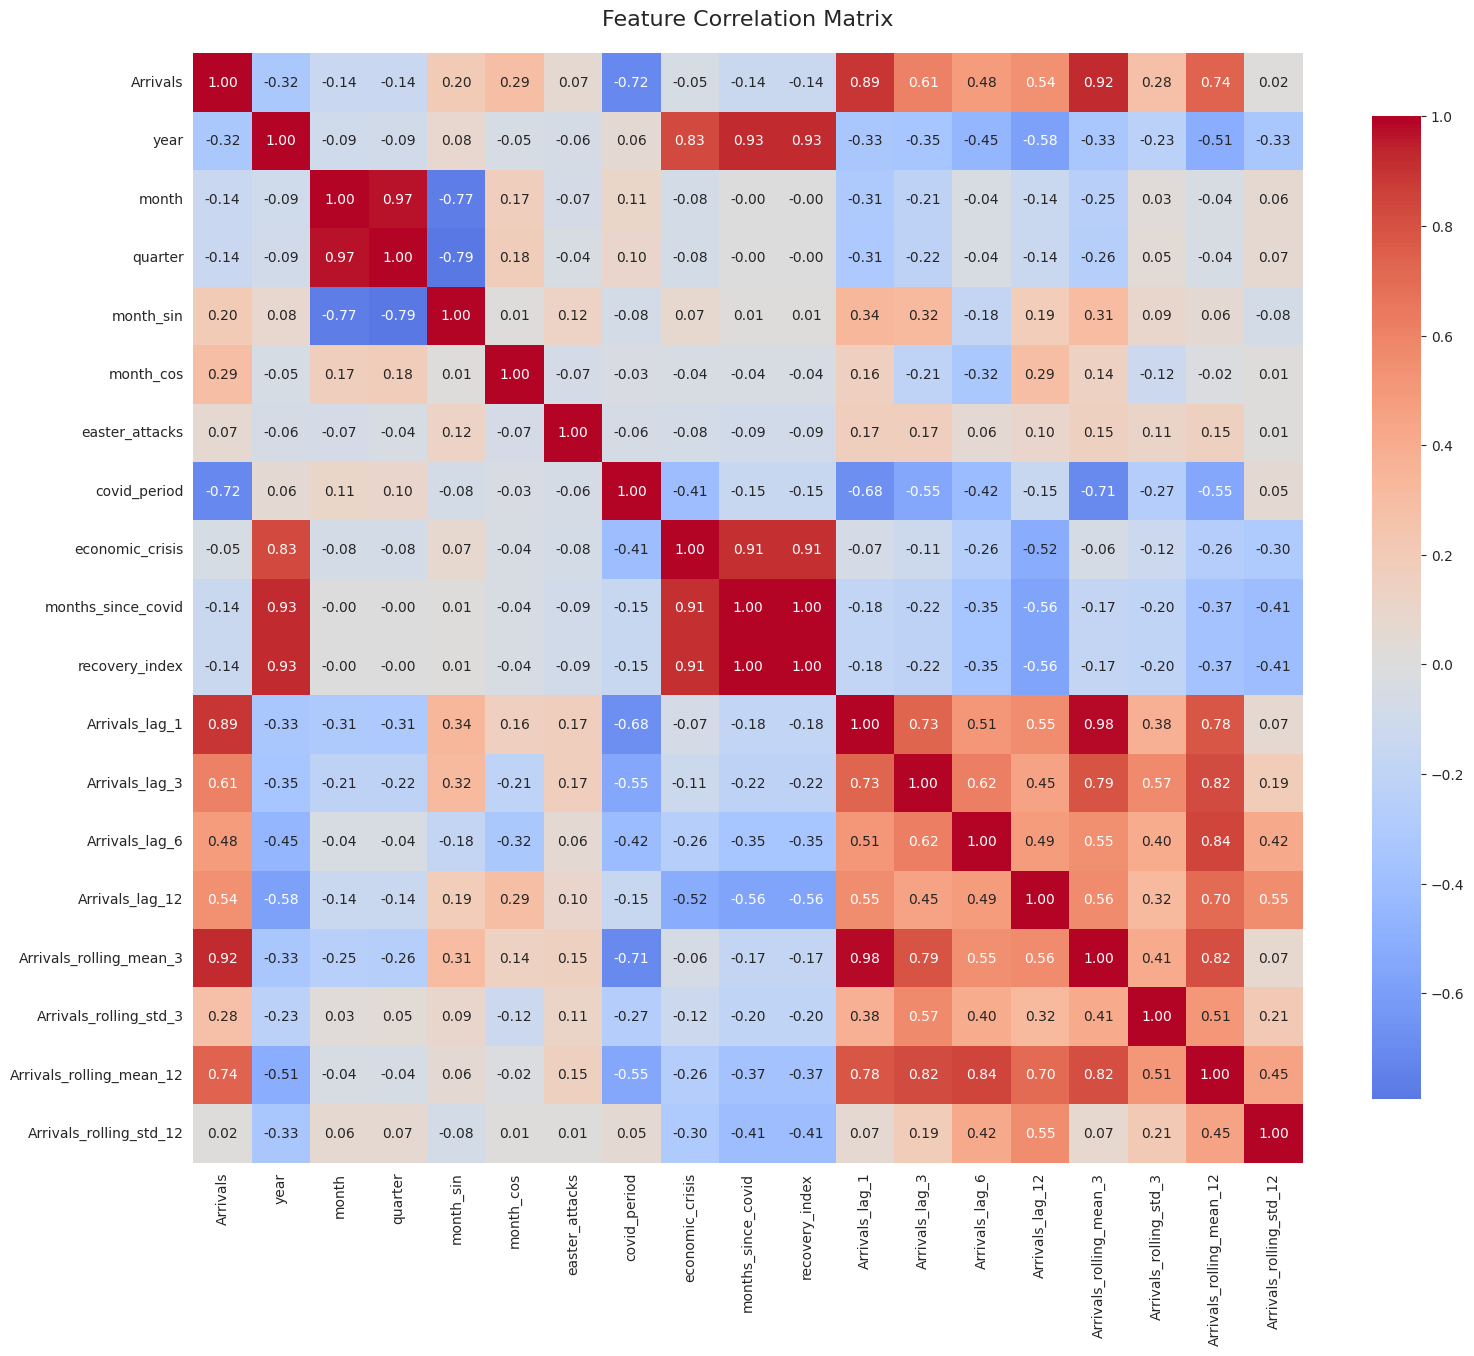


Features most correlated with Arrivals:
Arrivals                    1.000000
Arrivals_rolling_mean_3     0.923318
Arrivals_lag_1              0.894457
Arrivals_rolling_mean_12    0.740135
covid_period                0.715628
Arrivals_lag_3              0.611410
Arrivals_lag_12             0.544221
Arrivals_lag_6              0.484790
year                        0.324013
month_cos                   0.294879
Name: Arrivals, dtype: float64


In [14]:
# Select numeric features for correlation analysis (exclude Date)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation matrix
corr_matrix = df_features[numeric_cols].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Show strongest correlations with target
target_corr = corr_matrix['Arrivals'].abs().sort_values(ascending=False)
print("\nFeatures most correlated with Arrivals:")
print(target_corr.head(10))

## Summary

### Features Created:

**Parity Layer (All Models):**
- Temporal: year, month, quarter
- Interventions: easter_attacks, covid_period, economic_crisis, recovery_index

**Model-Specific:**
- Prophet: Uses parity layer + relies on built-in seasonality
- Neural Networks: Adds month_sin, month_cos for cyclical encoding
- ML/DL: Adds lag features (1, 3, 6, 12) and optionally rolling statistics

### Output Files:
1. `monthly_tourist_arrivals_features_full.csv` - All features (91 rows)
2. `monthly_tourist_arrivals_features_prophet.csv` - Prophet-ready (91 rows, no NaN)
3. `monthly_tourist_arrivals_features_ml.csv` - ML/DL features with NaN (91 rows)
4. `monthly_tourist_arrivals_features_ml_clean.csv` - ML/DL without NaN (79 rows)

### Key Design Decisions:
1. **Minimal features** to avoid overfitting on small dataset
2. **No leakage**: Rolling stats use only past data, interventions are deterministic
3. **Reusable**: Functions in `scripts/preprocessing.py` can be reused in production
4. **Interpretable**: Every feature has clear business meaning
5. **Model-aware**: Different feature sets optimized for different model types